In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
# import gower
from sklearn.neighbors import NearestNeighbors
from func import *
from helpers import *
import os
from pathlib import Path
import json
import yaml
import dask.dataframe as dd
import psycopg2

#### LOAD DATA

In [ ]:
import pandas as pd

df_base = pd.read_csv(
    "/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 1Q2023 tab-delimited (2)/IP_ED_BASE_DATA_1_1q2023_tab.txt",
    sep='\t'
)

df_grouper = pd.read_csv(
    "/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 1Q2023 tab-delimited (2)/IP_ED_GROUPER_1q2023_tab.txt",
    sep='\t'
)

df_ = df_base.merge(df_grouper, on = "RECORD_ID")
df = df_[['RECORD_ID', 'DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
       'PAT_ZIP', 'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS','SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY','ILLNESS_SEVERITY',
       'PAT_AGE', 'FIRST_PAYMENT_SRC', 'APR_MDC']]
df.head()       


/tmp/ipykernel_2054/4231633713.py:3: DtypeWarning: Columns (4,6,7,11,17,18,21,88,89,90,91,92,93,94,95,103,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base = pd.read_csv(


,RECORD_ID,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,ILLNESS_SEVERITY,PAT_AGE,FIRST_PAYMENT_SRC,APR_MDC
0,120232073717,2023Q1,1,9,78538,215.0,11.0,1,F,4,1.0,5,2,1,9,CI,14
1,120232073719,2023Q1,1,9,78577,215.0,11.0,1,F,4,1.0,3,2,1,8,HM,14
2,120232073722,2023Q1,1,9,78573,215.0,11.0,1,F,4,1.0,3,3,1,7,MC,14
3,120232073725,2023Q1,1,9,78582,427.0,11.0,1,F,4,1.0,3,4,1,7,HM,14
4,120232073729,2023Q1,1,9,78573,215.0,11.0,1,F,4,1.0,3,3,2,10,BL,14


In [ ]:
cat_cols = df[['DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION','ILLNESS_SEVERITY','PUBLIC_HEALTH_REGION', 'PAT_STATUS','SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY','PAT_AGE', 'APR_MDC']]
le = LabelEncoder()
le.fit_transform(df['SEX_CODE']).dtype

df.replace('`', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

In [ ]:


# Convert everything to numeric if possible
df = df.apply(pd.to_numeric, errors="ignore")

# If still object columns remain, map them manually (like SEX_CODE = F/M)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category").cat.codes


/tmp/ipykernel_2054/534460970.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


/tmp/ipykernel_2054/3434238071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('`', np.nan, inplace=True)
/tmp/ipykernel_2054/3434238071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('', np.nan, inplace=True)
/tmp/ipykernel_2054/3434238071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


(377733, 17)

In [12]:
df.drop(columns=['RECORD_ID','FIRST_PAYMENT_SRC'], inplace = True)

/tmp/ipykernel_2054/4202868097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['RECORD_ID','FIRST_PAYMENT_SRC'], inplace = True)


In [14]:
df.head()

,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,ILLNESS_SEVERITY,PAT_AGE,APR_MDC
0,1,1,6,78538.0,215.0,11.0,1,0,4,1.0,5,2,1,9,14
1,1,1,6,78577.0,215.0,11.0,1,0,4,1.0,3,2,1,8,14
2,1,1,6,78573.0,215.0,11.0,1,0,4,1.0,3,3,1,7,14
3,1,1,6,78582.0,427.0,11.0,1,0,4,1.0,3,4,1,7,14
4,1,1,6,78573.0,215.0,11.0,1,0,4,1.0,3,3,2,10,14


### PREDICTION OF SEVERITY

In [22]:
def preprocess(df):

    df_ = df.copy()
    cat_cols = ['DISCHARGE', 'SOURCE_OF_ADMISSION', 'ILLNESS_SEVERITY',
                'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY','PAT_AGE','APR_MDC']
    for col in cat_cols:
        df_[col] = df_[col].astype(str)
        le = LabelEncoder()
        df_[col] = le.fit_transform(df_[col])
    num_cols = ['LENGTH_OF_STAY']
    X = df_[cat_cols + num_cols]
    y = df_['TYPE_OF_ADMISSION']
    return X, y

Accuracy: 0.9208175043350497
classification_report.              precision    recall  f1-score   support

           0       0.93      0.99      0.96     69155
           1       0.58      0.12      0.20      3203
           2       0.59      0.14      0.23      1335
           3       1.00      0.94      0.97        18
           4       0.61      0.11      0.18      1661
           5       0.50      0.05      0.08       175

    accuracy                           0.92     75547
   macro avg       0.70      0.39      0.44     75547
weighted avg       0.90      0.92      0.90     75547



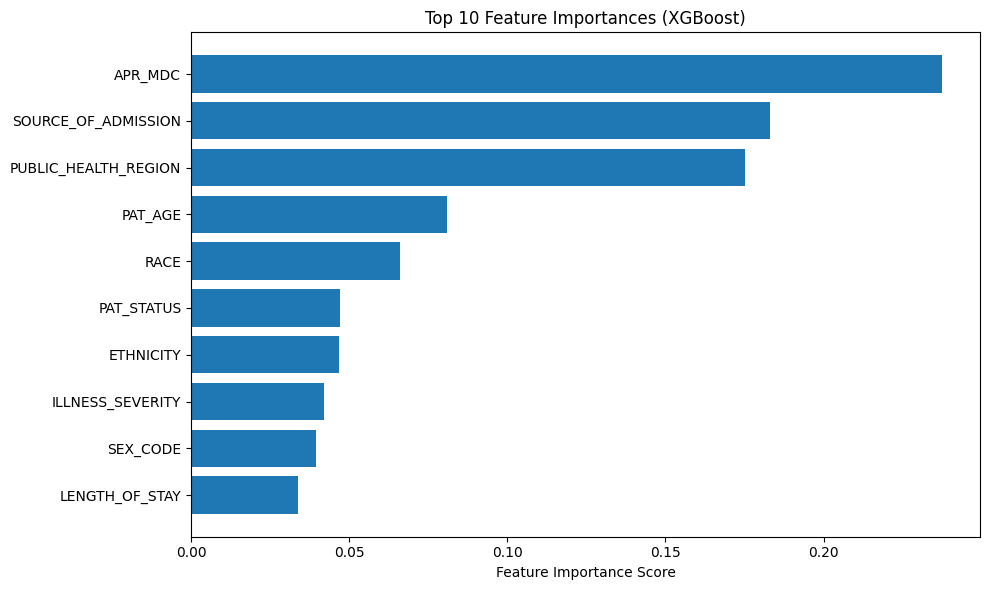

In [23]:
# Main block
def run_main(df):
    if __name__ == "__main__":
        X, y = preprocess(df)
        y_enc = le.fit_transform(y)
        X.dtypes, y_enc.dtype
        # X_pca = preprocess_pca(X)
        model = XGBClassifier(
        objective='multi:softprob',
        # n_estimators=200,
        # learning_rate=0.001,
        # max_depth=15,
        random_state=42,
        enable_categorical=True,
        eval_metric='mlogloss'
    )
        # model = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
        model, X_test, y_test = train_model(model, X, y_enc)
        df_preds = eval_model(model, X_test, y_test)
        return df_preds
df_preds = run_main(df)
# plt.hist(preds)

### IPF

In [24]:
df.columns

Index(['DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION', 'PAT_ZIP',
       'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE',
       'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY', 'ILLNESS_SEVERITY',
       'PAT_AGE', 'APR_MDC'],
      dtype='object')

In [21]:
df['TYPE_OF_ADMISSION'].value_counts()

TYPE_OF_ADMISSION
1    345362
2     16199
5      8515
3      6613
9       935
4       109
Name: count, dtype: int64

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sdv.tabular import CTGAN

ModuleNotFoundError: No module named 'sdv'

In [70]:
df['SEX_CODE'].value_counts()

SEX_CODE
0    214960
1    162769
2         4
Name: count, dtype: int64

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ctgan import CTGAN
import torch

# ---------------------------------------------
# 1️⃣ Train/test split
# ---------------------------------------------
def train_split(df, target_col='APR_MDC', test_size=0.25, random_state=42):
    df_train, df_test = train_test_split(
        df,
        test_size=test_size,
        stratify=df[target_col],
        random_state=random_state
    )
    return df_train, df_test


# ---------------------------------------------
# 2️⃣ IPF synthetic demographic generation
# ---------------------------------------------
def generate_ipf(df, features, target_marginals, tol=1e-5, max_iter=100):
    df = df.copy()
    df['weight'] = 1.0

    for iteration in range(max_iter):
        old_weights = df['weight'].copy()
        for feat in features:
            current = df.groupby(feat)['weight'].sum()
            desired = pd.Series(target_marginals[feat])
            ratios = desired / current
            df['weight'] *= df[feat].map(ratios)

        if np.allclose(df['weight'], old_weights, atol=tol):
            print(f"✅ IPF converged at iteration {iteration}")
            break

    # Sample synthetic dataset proportional to weights
    synthetic_demographics = df.sample(
        n=len(df),
        weights='weight',
        replace=True,
        random_state=42
    ).drop(columns=['weight'])
    return synthetic_demographics


# ---------------------------------------------
# 3️⃣ Learn CTGAN on real data
# ---------------------------------------------
def learn_gan(df_real, demographic_features, target_col='APR_MDC', epochs=5, batch_size=128):
    columns_to_use = demographic_features + [target_col]
    df_ctgan = df_real[columns_to_use].copy()

    # Convert to categorical
    for col in columns_to_use:
        df_ctgan[col] = df_ctgan[col].astype('category')

    discrete_columns = columns_to_use

    # Limit CPU threads to reduce OOM errors
    torch.set_num_threads(1)

    ctgan = CTGAN(epochs=epochs, verbose=True)
    print("🚀 Training CTGAN...")
    ctgan.fit(df_ctgan, discrete_columns=discrete_columns)
    print("✅ CTGAN training complete!")
    return ctgan


# ---------------------------------------------
# 4️⃣ Generate diagnostics conditioned on demographics
# ---------------------------------------------
def generate_gan(ctgan, synthetic_demographics, target_col='APR_MDC'):
    df_demo = synthetic_demographics.copy()

    # Drop old APR_MDC if present
    if target_col in df_demo.columns:
        df_demo = df_demo.drop(columns=[target_col])

    # Ensure categorical
    for col in df_demo.columns:
        df_demo[col] = df_demo[col].astype('category')

    print(f"🚀 Generating synthetic {target_col} for {len(df_demo)} rows...")
    synthetic_data = ctgan.sample(len(df_demo))

    # Merge with synthetic demographics
    df_final = pd.concat([
        df_demo.reset_index(drop=True),
        synthetic_data[[target_col]].reset_index(drop=True)
    ], axis=1)

    print(f"✅ Final synthetic dataset with demographics + {target_col}:")
    print(df_final.head())
    return df_final


# ---------------------------------------------
# 5️⃣ Main pipeline
# ---------------------------------------------
if __name__ == "__main__":
    # Example: replace with your actual dataframe
    # df = pd.read_parquet("path/to/your/data.parquet")
    print("⚙️ Starting synthetic data generation pipeline...")

    # Example: required columns
    features = [
        'SEX_CODE', 'PAT_AGE', 'RACE', 'ETHNICITY',
        'PAT_ZIP', 'PAT_COUNTY', 'PUBLIC_HEALTH_REGION'
    ]
    target_col = 'APR_MDC'

    # Reduce dataset size for stability
    df_small = df.sample(n=min(100000, len(df)), random_state=42)
    print(f"Using reduced dataset with {len(df_small)} rows")

    # Split dataset
    df_train, df_test = train_split(df_small, target_col=target_col)

    # Compute marginals for IPF
    target_marginals = {col: df_train[col].value_counts().to_dict() for col in features}

    # Step 1: Generate synthetic demographics using IPF
    synthetic_demographics = generate_ipf(df_train, features, target_marginals)

    # Step 2: Train CTGAN on real data (demographics + APR_MDC)
    ctgan_model = learn_gan(df_train, features, target_col=target_col, epochs=5)

    # Step 3: Generate synthetic APR_MDC outcomes for IPF demographics
    synthetic_dataset = generate_gan(ctgan_model, synthetic_demographics, target_col=target_col)

    # Step 4: Save the results
    synthetic_dataset.to_parquet("synthetic_population_with_aprmdc.parquet", index=False)
    print("💾 Synthetic dataset saved as synthetic_population_with_aprmdc.parquet")


⚙️ Starting synthetic data generation pipeline...
Using reduced dataset with 100000 rows
✅ IPF converged at iteration 0
🚀 Training CTGAN...


Gen. (0.92) | Discrim. (0.00): 100%|██████████| 5/5 [10:59<00:00, 131.87s/it] 


✅ CTGAN training complete!
🚀 Generating synthetic APR_MDC for 75000 rows...
✅ Final synthetic dataset with demographics + APR_MDC:
  DISCHARGE TYPE_OF_ADMISSION SOURCE_OF_ADMISSION  PAT_ZIP PAT_COUNTY  \
0         1                 1                   7  77511.0       39.0   
1         1                 1                   7  77651.0      245.0   
2         1                 1                   7  76103.0      439.0   
3         1                 1                   0  76114.0      439.0   
4         1                 2                   8  75227.0      113.0   

  PUBLIC_HEALTH_REGION PAT_STATUS SEX_CODE RACE ETHNICITY ADMIT_WEEKDAY  \
0                  6.0          7        0    4       2.0             2   
1                  5.0          6        1    4       2.0             1   
2                  3.0          1        0    5       1.0             6   
3                  3.0          3        0    4       2.0             7   
4                  3.0          1        0    4       1

In [98]:
synthetic_dataset.shape


(75000, 15)

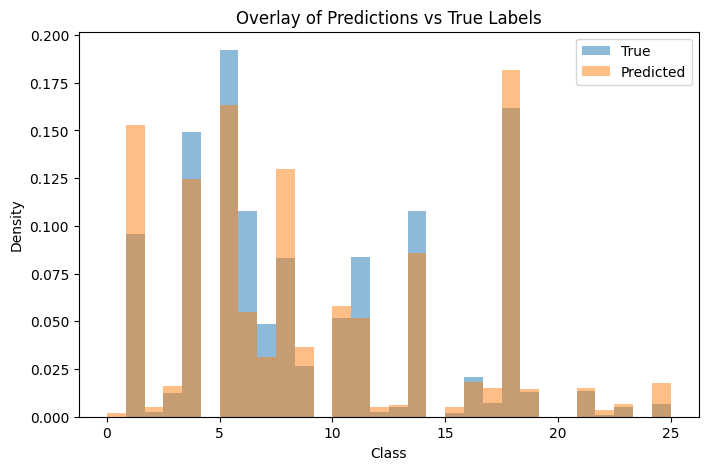

ValueError: operands could not be broadcast together with shapes (377733,) (75000,) 

In [81]:
dist_match(df['APR_MDC'], synthetic_dataset['APR_MDC'])

In [ ]:
real_counts = df['APR_MDC'].value_counts(normalize=True)
synthetic_counts = synthetic_dataset['APR_MDC'].value_counts(normalize=True)

all_classes = real_counts.index.union(synthetic_counts.index)
real_dist_aligned = real_counts.reindex(all_classes, fill_value=0)
synthetic_dist_aligned = synthetic_counts.reindex(all_classes, fill_value=0)

js_div = jensenshannon(real_dist_aligned.values, synthetic_dist_aligned.values)
print(f"Jensen-Shannon divergence: {js_div:.4f}")



Jensen-Shannon divergence: 0.1279


In [82]:
synthetic_dataset.to_csv("synthetic_dataset.csv")

In [ ]:
df_demog = df[['PAT_ZIP','PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE','ETHNICITY']]
features = ['PAT_ZIP','PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE','ETHNICITY']
import pandas as pd
import numpy as np


def iterative_proportional_fitting(df, features, target_marginals, tol=1e-5, max_iter=100):
    # Start with equal weights
    df['weight'] = 1.0

    for iteration in range(max_iter):
        old_weights = df['weight'].copy()

        for feat in features:
            # Compute current marginal sums
            current = df.groupby(feat)['weight'].sum()
            desired = pd.Series(target_marginals[feat])

            # Compute adjustment ratios
            ratios = desired / current
            df['weight'] *= df[feat].map(ratios)

        # Check convergence
        if np.allclose(df['weight'], old_weights, atol=tol):
            print(f"Converged at iteration {iteration}")
            break

    return df

# Example usage

known_marginals = {}
for col in features:
    counts = df_base[col].value_counts().to_dict()
    known_marginals[col] = counts

synthetic_df = iterative_proportional_fitting(df_base.copy(), features, known_marginals)


In [ ]:
synthetic_population = synthetic_df.sample(
    n=len(df),  # same size as original
    weights='weight',
    replace=True,   
    random_state=42
).drop(columns=['weight'])

In [32]:
synthetic_population

,RECORD_ID,DISCHARGE,THCIC_ID,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,...,OTH_SURG_PROC_DAY_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,PROVIDER_NAME,EMERGENCY_DEPT_FLAG
166964,120230959380,2023Q1,154001,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9894505236,NaN,1,Methodist Specialty & Transplant Hospital,Y
421652,120231906092,2023Q1,180000,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9710787100,1.450981e+09,1,Las Palmas Medical Center,Y
325878,120232017111,2023Q1,675000,1,1,I,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4218985410,NaN,1,HCA Houston Healthcare Kingwood,Y
266260,120232270626,2023Q1,1000,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5346127290,NaN,1,BSA Hospital,Y
69783,120231798598,2023Q1,975205,1,1,I,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6838183098,NaN,1,Texas Childrens Hospital The Woodlands,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373745,120232066246,2023Q1,503001,2,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1862985530,NaN,1,St Lukes Baptist Hospital,Y
360919,120231765442,2023Q1,19000,1,1,I,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2959592082,NaN,1,Valley Regional Medical Center,Y
59485,120231984670,2023Q1,340000,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8859060015,NaN,1,Medical City Dallas Hospital,Y
416767,120232156722,2023Q1,286000,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5514009448,1.890930e+09,1,Christus Mother Frances Hospital Tyler,Y


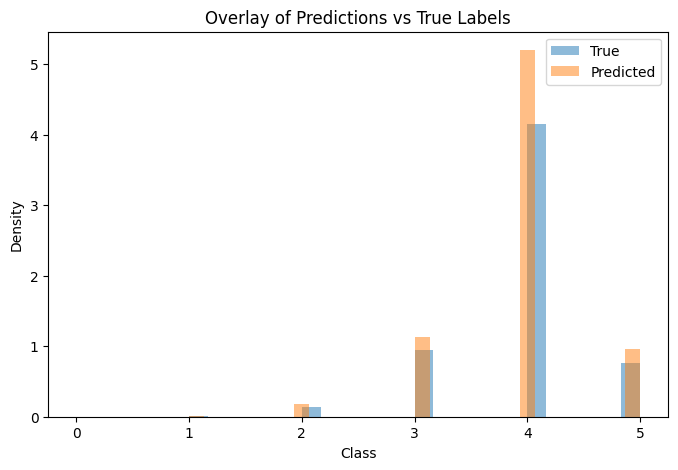

Jenson Shannon 0.08378247592902813


: 

In [ ]:
synthetic_population['RACE'] = (
    pd.to_numeric(synthetic_population['RACE'], errors='coerce')
    .fillna(0)
    .astype(int)
)

# synthetic_population['RACE'].value_counts(normalize=True), 
# df['RACE'].value_counts(normalize=True)
dist_match(synthetic_population['RACE'], df['RACE'])

In [47]:
df.dtypes

DISCHARGE                  int8
TYPE_OF_ADMISSION         int64
SOURCE_OF_ADMISSION        int8
PAT_ZIP                 float64
PAT_COUNTY              float64
PUBLIC_HEALTH_REGION    float64
PAT_STATUS                int64
SEX_CODE                   int8
RACE                      int64
ETHNICITY               float64
ADMIT_WEEKDAY             int64
LENGTH_OF_STAY            int64
ILLNESS_SEVERITY          int64
PAT_AGE                   int64
APR_MDC                   int64
dtype: object

(array([2., 1., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0.23733333,  7.1468    , 14.05626667, 20.96573333, 27.8752    ,
        34.78466667, 41.69413333, 48.6036    , 55.51306667, 62.42253333,
        69.332     ]),
 <BarContainer object of 10 artists>)

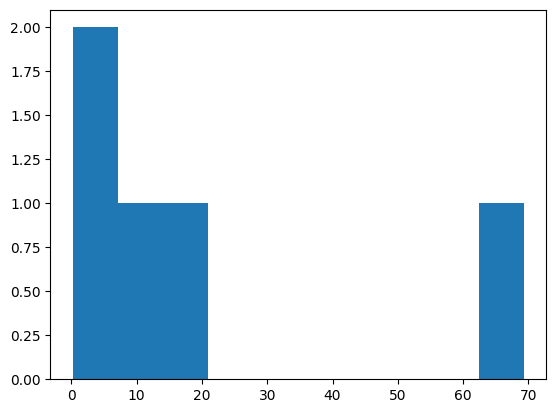

In [101]:
sr = synthetic_dataset['RACE'].value_counts(normalize=True)
dr = df['RACE'].value_counts(normalize=True)
# dist_match(sr,dr)
plt.hist(sr*100)
# plt.bar(dr)
# sr